In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import tqdm.notebook as tqdm
from collections import Counter
import lemmy
plt.style.use("classic")

import requests
from bs4 import BeautifulSoup
import re
import json

#Text Analysis
import nltk
from nltk.corpus import stopwords

import spacy
import da_core_news_md as da
import lemmy.pipe

try:
    nlp = da.load()
    pipe = lemmy.pipe.load('da')
    nlp.add_pipe(pipe, after='tagger')
except ValueError:
    None




%matplotlib inline

### Group 2

In [2]:
def houses_boliga(number_houses):
    """
    Returns a list of all ids for houses on boliga
    
    """
    house_id = list()
    url = "https://www.boliga.dk/resultat"
    
    for i in range(int(number_houses/50)):
        new_url = url + f"?page={i}"
        response = requests.get(new_url)
        html = response.text
        soup = BeautifulSoup(html,"html.parser")
        ids = soup.find_all("a",{"class":"house-list-item"})
        link_houses = list()

        for link in ids:
            link_houses.append(re.findall("(/\d{4,}/)",link["href"])[0].replace("/",""))
        
        house_id.extend(link_houses)
        
    return house_id

def get_info(id_list):
    
    """
    Take an list with ids of houses on boliga and gets specific data about these ids
    
    """
    all_df = list()
    new_keys = ["registeredArea","downPayment","estateUrl","currentArchiveId","forSaleNowId",
                "foreclosureId","selfsaleEstateId","cleanStreet","estateId","latitude","longitude",
               "propertyType","priceChangePercentTotal","energyClass","price","rooms","size","lotSize",
               "floor","buildYear","city","isActive","municipality","zipCode","street",
                "squaremeterPrice","daysForSale","createdDate","basementSize","views"]
    
    for house_id in id_list:
        response = requests.get(f'https://api.boliga.dk/api/v2/estate/{house_id}')
        response = response.json()
        df_dict = {key: response[key] for key in new_keys}
        df = pd.DataFrame(df_dict,index=[0])
        all_df.append(df)

    df = pd.concat(all_df,axis=0,ignore_index=True)
    
    return df



def get_reviews(df):
    i = 0
    bodys = list()
    estates = list()
    estate_ids = list()
    
    #Finder alle ejendomsmæglere, som har mere end 100 huse til salg
    for value in df["estateUrl"].values:
        estates.append(value[8:15])
    numbers = dict(Counter(estates))
    over_100 = dict() 
    for key, value in numbers.items():
        if value > 100:
            over_100[key] = value
            
    #Kører igennem alle links og finder tilhørende beskrivelse
    for link in tqdm(df["estateUrl"].values):
        i += 1
        body_len_prior = len(bodys)
        try:
            response = requests.get(link)
            html = response.text
            soup = BeautifulSoup(html,"html.parser")
            
            if link[8:15] =="home.dk": #Home
                ids = soup.find_all("div",{"class":"text"},"p")
                bodys.extend([x.p.text.replace("\n","").strip().lower() for x in ids[0:1] if len(x)>1])
            elif link[8:15] =="ww.skbo": #skbolig
                ids = soup.find_all("div",{"class":"listing-text"})
                bodys.extend([sk.text.replace("\n","").replace("\r","").strip().lower() for sk in ids[0:1] if len(sk)>1])
            elif link[8:15] == "www.nyb": #Nybolig
                ids = soup.find_all("div",{"class":"foldable-spot__container"})
                bodys.extend([ny.text.replace("\n","").strip().lower() for ny in ids[0:1] if len(ny)>1])
            elif link [8:15] == "ww.elto": #Eltoft Nielsen
                ids = soup.find_all("br")
                bodys.extend([elto.text.replace("\n","").strip().lower() for elto in ids[0:1] if len(elto)>1])
            elif link[8:15] == "www.cla": #Claus Borg
                ids = soup.find_all("div",{"id":"case_content"})
                bodys.extend([cla.text.replace("\n","").strip().lower() for cla in ids[0:1] if len(cla)>1])
            elif link[8:15] == "www.lok": #Lokalbolig
                ids = soup.find_all("div",{"class":"css-s7itso eknr0ef1"})
                bodys.extend([lok.text.replace("\n","").strip() for lok in ids[0:1] if len(lok)>1])
            elif link[8:15] == "www.edc": #EDC Bolig
                ids = soup.find_all("div",{"class":"description"})
                bodys.extend([edc.text.replace("\n","").strip().lower() for edc in ids[0:1] if len(edc)>1])
            elif link[8:15] == "adamsch": #Adam Schnack
                ids = soup.find_all("div",{"class":"listing-text"})
                bodys.extend([adam.text.replace("\n","").strip().lower() for adam in ids[0:1] if len(adam)>1])
            elif link[8:20] == "www.estate.d": #Estate
                ids = soup.find_all("div",{"class":"property-description"})
                bodys.extend([est.text.replace("\n","").strip().lower() for est in ids[0:1] if len(est)>1])
            elif link[8:15] == "www.bri": #Brikk Ejendomme
                ids = soup.find_all("div",{"class":"prop-user-content"})
                bodys.extend([bri.text.replace("\n","").strip().lower() for bri in ids[0:1] if len(bri)>1])
            elif link[8:15] == "www.rea": #Realmæglerne
                ids = soup.find_all("div",{"class":"text-full"})
                bodys.extend([rea.text.replace("\n","").strip().lower() for rea in ids[0:1] if len(rea)>1])
            elif link[8:15] == "danboli": #Danbolig
                ids = soup.find_all("div",{"class":"db-description-block"})
                bodys.extend([dan.text.replace("\n","").strip().lower() for dan in ids[0:1] if len(dan)>1])
            elif link[8:15] == "ww.lili": #Lillenhof
                ids = soup.find_all("div",{"class":"inner"})
                bodys.extend([dan.text.replace("\n","").strip().lower() for dan in ids[0:1] if len(dan)>10])
            elif link[8:15] == "bjornby":
                ids = soup.find_all("div",{"class":"content d-md-block d-none wrap-content"})
                bodys.extend([bjor.text.replace("\n","").strip() for bjor in ids[0:1] if len(bjor)>10])
            elif link[8:15] == 'www.hov': #Hovmand
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([hov.text.replace("\n","").strip() for hov in ids[0:1] if len(hov)>1])
            elif link[8:15] == 'ww.jesp': #Jesper Nielsen
                ids = soup.find_all("div",{"class":"case-description"})
                bodys.extend([jesp.text.replace("\n","").strip() for jesp in ids[0:1] if len(jesp)>1])
            elif link[8:15] == "www.sel": #Selvsalg
                ids = soup.find_all("div",{"class":"tab-pane active fade in"})
                bodys.extend([selv.text.replace("\n","").strip() for selv in ids[0:1] if len(selv)>1])
            elif link[8:15] == "www.bol": #Bolig
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([bol.text.replace("\n","").strip() for bol in ids[0:1] if len(bol)>1])
            elif link[8:15] == 'www.joh': #Johns
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([john.text.replace("\n","").strip() for john in ids[0:1] if len(john)>1])
            elif link[8:15] == "racking": #Robinhus
                ids = soup.find_all("div",{"class":"text-container"})
                bodys.extend([robin.text.replace("\n","").strip() for robin in ids[0:1] if len(robin)>1])
            elif link[8:15] == "www.min": #minbolighandel
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([minb.text.replace("\n","").strip() for minb in ids[0:1] if len(minb)>1])
            elif link[8:15] == "ww.unni": #Unnibolig
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([un.text.replace("\n","").strip() for un in ids[0:1] if len(un)>1])
            elif link[8:15] == "www.sdb": #Sdb bolig
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([un.text.replace("\n","").strip() for un in ids[0:1] if len(un)>1])
            elif link[8:15] == "ww.land":#Landobolig
                ids = soup.find_all("div",{"class":"col-md-8"})
                bodys.extend([land.text.replace("\n","").strip() for land in ids[0:1] if len(land)>1])
            elif link[8:15] == "www.ber": #Bermistof
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([ber.text.replace("\n","").strip() for ber in ids[0:1] if len(ber)>1])
            elif link [8:20] == 'www.carlsber': #Carlsberg Byen
                ids = soup.find_all("div",{"itemprop":"description"})
                bodys.extend([car.text.replace("\n","").strip() for car in ids[0:1] if len(car)>1])
            elif link[8:15] == "www.car": #Carsten Nordbo
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([car.text.replace("\n","").strip() for car in ids[0:1] if len(car)>1])
            elif link[8:15] == 'ww.agri': 
                ids = soup.find_all("div",{"class":"col-md-8 col-sm-7 hidden-xs text-box desktop"})
                bodys.extend([agr.text.replace("\n","").strip() for agr in ids[0:1] if len(agr)>1])
            elif link[8:15] == "www.pla":#Place2Live
                ids = soup.find_all("div",{"class":"col-lg-16"})
                bodys.extend([pla.text.replace("\n","").strip() for pla in ids[0:1] if len(pla)>1])
            elif link[8:15] == "www.vil": #Villadsenbolig
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([vil.text.replace("\n","").strip() for vil in ids[0:1] if len(vil)>1])
            elif link[8:15] == 'maegler': #Mæglerhuset
                ids = soup.find_all("div",{"class":"case-text"})
                bodys.extend([mae.text.replace("\n","").strip() for mae in ids[0:1] if len(mae)>1])
            elif link[8:15] == 'ww.thom': #ThomasJørgensen
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([thom.text.replace("\n","").strip() for thom in ids[0:1] if len(thom)>1])
            elif link[8:15] == 'www.htb': #HTbolig
                ids = soup.find_all("div",{"class":"left-side global-style"})
                bodys.extend([htb.text.replace("\n","").strip() for htb in ids[0:1] if len(htb)>1])
            elif link[8:15] == 'ww.boli': #Boligone
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([bol.text.replace("\n","").strip() for bol in ids[0:1] if len(bol)>1])
            elif link[8:15] == "www.mæg":#Mæglerringen
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([ma.text.replace("\n","").strip() for ma in ids[0:1] if len(ma)>1])
            elif link[8:15] == "ww.vest":
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([vest.text.replace("\n","").strip() for vest in ids[0:1] if len(vest)>1])
            elif link[8:15] == "www.tho": #Thorregård
                ids = soup.find_all("div",{"class":"annonce rammebaggrund"})
                bodys.extend([th.text.replace("\n","").strip() for th in ids[0:1] if len(th)>1])
            elif link[8:15] == "byggegr": #Byggegrund
                ids = soup.find_all("div",{"class":"section section-12"})
                bodys.extend([byg.text.replace("\n","").strip() for byg in ids[0:1] if len(byg)>1])
            elif link[8:15] == "grundsa": #Grundsalg
                bodys.append(np.nan)
            elif link[8:15] == "rundsal": #Grundsalg
                bodys.append(np.nan)
            elif link[8:15] =="ww.paul": #paulun
                bodys.append(np.nan)
            else:
                bodys.append(np.nan)
        except:
            bodys.append(np.nan)
            print(link,"virkede ikke")
            continue
        
        body_len_after = len(bodys)
        fixed_change = body_len_prior + 1
        
        try:
            bodys = bodys[0:fixed_change]
        except:
            None
            
        if body_len_after == body_len_prior + 1:
            estate_ids.append(df[df["estateUrl"]==link]["currentArchiveId"].values[0])
    bodys_df = pd.DataFrame({"currentArchiveId":estate_ids,"body":bodys})
    
    return bodys_df

def find_realtors(df):
    """
    This function finds all realtors, who has more that 100 houses for sale.
    Used to find the structure for all realtors of relevance
    """
    realtors_link = list()
    #Finder alle ejendomsmæglere, som har mere end 100 huse til salg
    estates = list()
    for value in df["estateUrl"].values:
        estates.append(value[8:15])
    numbers = dict(Counter(estates))

    over_100 = dict() 
    for key, value in numbers.items():
        if value > 100:
            over_100[key] = value
    already_accounted = list()
    for link in tqdm.tqdm(df["estateUrl"].values):        
        if link[8:15] in over_100.keys():
            if link[8:15] not in already_accounted:
                print(link,"not in loop")
                print(link[8:15])
                realtors_link.append(link[8:15])
                already_accounted.append(link[8:15])

    return realtors_link
    
def add_keyattr(df):
    key_attr = pd.read_csv("keywords.csv",sep=";") #Getting keyword file
    #Finding all words corresponding to group
    ref_list = [key_attr.loc[(key_attr["group"] == "view_list")|(key_attr["group_2"] == "view_list")|\
                         (key_attr["group_3"] == "view_list"), "word"],
                key_attr.loc[(key_attr["group"] == "nature_list")|(key_attr["group_2"] == "nature_list")|\
                         (key_attr["group_3"] == "nature_list"), "word"],
                key_attr.loc[(key_attr["group"] == "interior_list")|(key_attr["group_2"] == "interior_list")|\
                         (key_attr["group_3"] == "interior_list"), "word"],
                key_attr.loc[(key_attr["group"] == "location_list")|(key_attr["group_2"] == "location_list")|\
                         (key_attr["group_3"] == "location_list"), "word"],
               key_attr.loc[(key_attr["group"] == "other_list")|(key_attr["group_2"] == "other_list")|\
                         (key_attr["group_3"] == "other_list"), "word"]]
    
    #Generation dict for attr
    dict_att = {"view":list(),
                "nature":list(),
                "interior":list(),
                "location":list(),
               "other":list()}
    
    for body in df["bodys"].tolist():
        #Generating string
        nouns = preprocess_text(body)
        for value,cross_list in zip(dict_att.values(),ref_list):
            #Generating view key attr
            value.append(len(list(set(nouns).intersection(cross_list))))
    
    added_df = pd.DataFrame(dict_att)
    df = df.join(added_df)
    
    return df

def preprocess_csv(csv):
    """
    This function loads the dataset from boliga annd preproccesses it.
    """
    df = pd.read_csv(csv,index_col="Unnamed: 0")
    y = df["price"]
    
    #Making room per sqm
    df["rooms_per_sqm"] = (df["rooms"]/df["size"]).replace(np.inf,0)
    
    
    #Removing houses not placed in Denmark
    df = df[(df["latitude"]<60) & (df["latitude"]>53) & (df["longitude"]>7) & (df["longitude"]<16)]
    
    #Generating dummy variables - Property type
    housing_type={1:'villa',2:'raekkehuse', 3:'ejerlejlighed',4:'fritidshus', 5:'andel',6:'landejendom', 
              7:'helrsgrund',8:'fritidsgrund', 9:'villalejlighed',10:'andet_1',11:"andet_2",12:"andet_3"}
    dummy_df = pd.get_dummies(df['propertyType'].replace(housing_type))   
    df = df.join(dummy_df)
    df.drop("propertyType",axis=1,inplace=True)
    #df.rename(columns = housing_type,inplace=True)
    
    #Dropping all None house
    df = df[(df["helrsgrund"] == 0) & (df["andet_3"] == 0)]
    
    
    #Generation dummies variables - Kommune
    dummy_mun = pd.get_dummies(df["kommune_navn"])
    df = df.join(dummy_mun)
    df.drop("kommune_navn",inplace=True,axis=1)
    
    #Generation dummies variables - Floor
    dummy_floor = pd.get_dummies(df["floor"].map(str))
    df = df.join(dummy_floor)
    df.drop("floor",inplace=True,axis=1)

    
    #Dropping all non essential columns
    df.drop(["downPayment","estateUrl","currentArchiveId","forSaleNowId",
            "foreclosureId","cleanStreet","estateId","latitude","longitude","energyClass",
            "price","city","isActive","municipality","zipCode","street","createdDate",
            "squaremeterPrice","region","kommune_nr","rooms"],axis=1,inplace=True)
    df.dropna(inplace=True,axis=0)
    #Adding keyattr to df
    #df = add_keyattr(df)
    
    X = df.values
    y = y[df.index].values
    
    return X, y, df

def preprocess_text(string,nlp=nlp):
    """
    This function takes a string and returns a list with all noun from string lemmatized
    """

    #Removing everything but words
    string = re.sub(r'[^\w\s]','',string)
    
    #Removing stopwords
    stop_words_list = stopwords.words("danish")
    string = [i for i in nltk.word_tokenize(string.lower()) if i not in stop_words_list]
    string = " ".join(string)
    
    #Getting all nounce
    string = nlp(string)
    nouns = [word._.lemmas[0] for word in string if word.pos_ == "NOUN"]
    
    return nouns

def words_count(list_of_strings):
    """
    This function takes a list of strings and returns a dict with counts of each word
    """
    
    sentences = list_of_strings
    counts = dict(Counter(sentences))
    
    return counts

def keywords(body):
    """
    This function takes a list of different strings and returns a dataframe with each word and word count
    """
    
    word_list = list()
    
    for bodys in tqdm.tqdm(body):
        string = preprocess_text(bodys[0])
        word_list.extend(string)
        
    dict_count = words_count(word_list)
    df = pd.DataFrame({"word":list(dict_count.keys()),
                        "count":list(dict_count.values())}).set_index("word")
    
    #Getting the 300 largest counts returns the keywords used for key attr list
    return df
    
def add_lonlat(df,df_station):
    """
    This function takes two df and returns the distance between two locations of the dataframes location columns
    """
    
    min_dist = list()
    for location in tqdm(df["location"]):
        distance = list()
        for lon,lat in zip(df_station["lon"],df_station["lat"]):
            distance.append(geodesic((lat,lon), location).km)
    
        min_dist.append(min(distance))
        
    df["dist_station"] = min_dist
    
    return df

def next_preprocess(X,y,random_state=None):
    #Preparing transformer, for all but dummy variables
    ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,11]),
                    ("scaler",StandardScaler(),[0,11])],remainder="passthrough")


    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        random_state=random_state,
                                                        test_size=0.33)
    
    X_test = ct.fit_transform(X_test)
    X_train = ct.transform(X_train)
    
    
    return X_train, X_test, y_train, y_test


## ML

In [7]:
#ML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [4]:
def next_preprocess(X,y,random_state=None):
    #Preparing transformer, for all but dummy variables
    ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,11]),
                    ("scaler",StandardScaler(),[0,11])],remainder="passthrough")
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        random_state=random_state,
                                                        test_size=0.33)
    
    X_test = ct.fit_transform(X_test)
    X_train = ct.transform(X_train)
    
    return X_train, X_test, y_train, y_test

def display_scores(scores):
    print("Scores",scores)
    print("Mean:",scores.mean())
    print("Standard Deviation",scores.std())
    


In [5]:
X, y, df = preprocess_csv("house_data_final.csv")
X_train, X_test, y_train, y_test = next_preprocess(X,y)
y=y/1e+6

In [6]:
ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,11]),
                    ("scaler",StandardScaler(),[0,11])],remainder="passthrough")
X_fitted = ct.fit_transform(X)

### Testing different Models

In [7]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg,X_fitted,y,scoring="neg_mean_squared_error",cv=10)

rmse_scores = np.sqrt(-lin_scores)
display_scores(rmse_scores)

Scores [3.87106866 3.95474695 1.32774285 1.84578014 1.52570378 1.7714184
 1.81491189 1.64078817 1.31925745 1.56321443]
Mean: 2.063463271531557
Standard Deviation 0.9408538897664241


In [8]:
ran_reg = RandomForestRegressor(max_features=6,n_estimators = 54) #Getting best estimators from gridsearch
ran_scores = cross_val_score(ran_reg,X,y,scoring="neg_mean_squared_error",cv=10)

lin_rmse_scores = np.sqrt(-ran_scores)
display_scores(lin_rmse_scores)

Scores [2.37571006 3.43716916 1.15790938 1.4370493  1.33311078 1.3277558
 1.00131393 1.41242737 0.98313091 1.076652  ]
Mean: 1.554222868987765
Standard Deviation 0.7328938585084165


In [9]:
des_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(des_reg,X,y,scoring="neg_mean_squared_error",cv=10)

tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores [2.96121526 3.84172847 1.91591413 1.85621071 1.73629982 1.58112328
 1.28816535 1.81378853 1.52725955 1.44576994]
Mean: 1.9967475040121507
Standard Deviation 0.7523677163932851


In [10]:
ridge_reg = Ridge(max_iter=2000)
ridge_scores = cross_val_score(ridge_reg,X_fitted,y,scoring="neg_mean_squared_error",cv=10)

ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61898e-25): result may not be accurate.
  overwrite_a=True).T
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.46438e-26): result may not be accurate.
  overwrite_a=True).T
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.72203e-26): result may not be accurate.
  overwrite_a=True).T
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.4632e-26): result may not be accurate.
  overwrite_a=True).T
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.48142e-26): result may not be acc

Scores [3.86169066 3.9538282  1.31777743 1.84402866 1.52502447 1.76807829
 1.80359446 1.63696014 1.31769497 1.53197813]
Mean: 2.0560655398929244
Standard Deviation 0.9421255298794935


/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.46384e-26): result may not be accurate.
  overwrite_a=True).T
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.842e-26): result may not be accurate.
  overwrite_a=True).T


In [11]:
lasso_reg = Lasso(max_iter=2000)
lasso_scores = cross_val_score(lasso_reg,X_fitted,y,scoring="neg_mean_squared_error",cv=10)

lasso_rmse_scores = np.sqrt(-lasso_scores)
display_scores(lasso_rmse_scores)

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81044.81618795171, tolerance: 21.90654650860169
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6975.457144389147, tolerance: 17.705942172738705
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108289.26325321084, tolerance: 27.44555149539335
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did no

Scores [4.05601726 4.31400801 1.23891026 1.65755428 1.65328653 1.55707476
 1.61539636 1.68697996 1.36823058 1.66833724]
Mean: 2.0815795247371773
Standard Deviation 1.0622260482281622


/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106103.81132891218, tolerance: 27.41008303680032
  positive)


In [17]:
X_train, X_test, y_train, y_test = next_preprocess(X,y)
ran_test = RandomForestRegressor(max_features=6,n_estimators=55)
ran_test.fit(X_train,y_train)
r2_score(y_test,ran_test.predict(X_test))

0.6703916855173625

### Getting best estimators

In [215]:
param_grid = {"n_estimators":list(range(50,60))}
ran_search = GridSearchCV(ran_reg,param_grid,cv=9,scoring="neg_mean_squared_error")
ran_search.fit(X_train,y_train)

GridSearchCV(cv=9, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=6,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=54, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=Non

In [216]:
ran_search.best_params_

{'n_estimators': 58}

### Plotting the validation curve

TypeError: 'Text' object is not callable

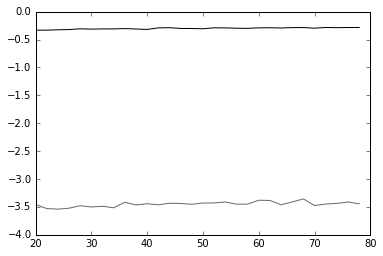

In [15]:
param_range = np.arange(20, 80, 2)
#Making validation curve
train_scores, test_scores = validation_curve(RandomForestRegressor(), 
                                             X, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="neg_mean_squared_error")
#Calculating Mean
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
fig, ax = plt.subplots()

ax.plot(param_range, train_mean, label="Training score", color="black")
ax.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
#ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
#ax.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
ax.title("Validation Curve With Random Forest")
ax.xlabel("Number Of Trees")
ax.ylabel("Neg Mean Squared Error")
ax.tight_layout()
ax.legend(loc="best")
ax.show()